# Analysis of Training Files

1. Do the test set and train set come from the same project?
2. How clean is the dataset? Is it script only? Is it coded by professionals with same style? Or mixed?

for test set vs validation set?

how many are class based / function based / both?

how many are inline code vs modular?

inline variable definition?

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# search training files
train_file_dir = 'train_files'
train_file_list = os.listdir(train_file_dir)

file_count = 0
for fp in train_file_list:
    if os.path.splitext(fp)[1].lower() != '.py':
        raise ValueError(f'unknown file! {fp}')
    file_count += 1

df_train = pd.DataFrame(train_file_list, columns=[
    'filename'
])
df_train = df_train.reset_index()

print(f'found {len(df_train)} train files')

# search test files
test_file_dir = 'test_files'
test_file_list = os.listdir(test_file_dir)

file_count = 0
for fp in test_file_list:
    if os.path.splitext(fp)[1].lower() != '.py':
        raise ValueError(f'unknown file! {fp}')
    file_count += 1

df_test = pd.DataFrame(test_file_list, columns=[
    'filename'
])
df_test = df_test.reset_index()
print(f'found {len(df_test)} test files')

found 10000 train files
found 50 test files


In [2]:
def load_stats(df, files_dir):
    filenames = df['filename']
    # load line count
    non_empty_line_count = {}
    is_init = {}
    root_class_count = {}
    root_function_count = {}

    for fn in filenames:
        try:
            with open(os.path.join(files_dir, fn), 'r', encoding='utf-8', errors='ignore') as f :
                lines = f.readlines()
                lines = [l.strip('\n') for l in lines]
                lines = [l for l in lines if len(l.strip()) > 0]
                non_empty_line_count[fn] = len(lines)

                curr_is_init = '__init__.py' == fn[-1 * len('__init__.py'):]
                is_init[fn] = curr_is_init

                curr_root_class_count = len([l for l in lines if l[:len('class')] == 'class'])
                root_class_count[fn] = curr_root_class_count

                curr_root_function_count = len([l for l in lines if l[:len('def')] == 'def'])
                root_function_count[fn] = curr_root_function_count

        except Exception as e:
            print(fn)
            raise e

    df['non_empty_line_count'] = non_empty_line_count.values()
    df['is_init'] = is_init.values()
    df['root_class_count'] = root_class_count.values()
    df['root_function_count'] = root_function_count.values()
    
load_stats(df_test, test_file_dir)
load_stats(df_train, train_file_dir)

In [3]:
df_train.head()

,index,filename,non_empty_line_count,is_init,root_class_count,root_function_count
0,0,data_alan-hicks_django-dmarc_docs_conf.py,196,False,0,0
1,1,data_QingdaoU_OnlineJudge_utils_management_com...,17,False,1,0
2,2,data_all-umass_metric-learn_metric_learn_lsml.py,118,False,1,1
3,3,data_goodfeli_adversarial_parzen_ll.py,123,False,0,7
4,4,data_anhstudios_swganh_data_scripts_templates_...,12,False,0,1


In [4]:
df_test.head()

,index,filename,non_empty_line_count,is_init,root_class_count,root_function_count
0,0,data_ImageEngine_gaffer_python_GafferCortexUI_...,45,False,1,0
1,1,data_HewlettPackard_python-ilorest-library_src...,1829,False,17,0
2,2,data_Havate_havate-openstack_proto-build_gui_h...,31,False,3,0
3,3,data_ImageEngine_gaffer_python_GafferCortexTes...,59,False,1,0
4,4,data_IanLewis_django-lifestream_lifestream_rss.py,27,False,1,0


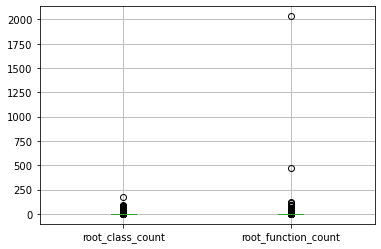

In [5]:
df_train.boxplot(column=['root_class_count', 'root_function_count'])

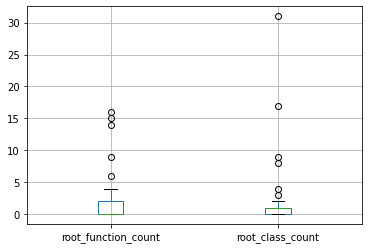

In [6]:
df_test.boxplot(column=['root_function_count', 'root_class_count'])

In [7]:
df_train.loc[df_train['root_class_count'].idxmax()]

index                                                                8440
filename                data_francelabs_datafari_windows_python_Lib_te...
non_empty_line_count                                                 3884
is_init                                                             False
root_class_count                                                      176
root_function_count                                                     2
Name: 8440, dtype: object

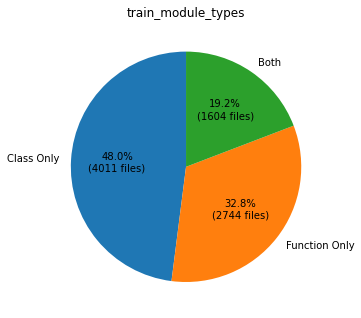

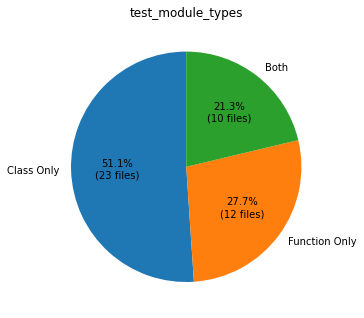

In [8]:


def module_pie(df, title):
    class_only = df[(df['root_class_count'] > 0) & (df['root_function_count'] == 0)]
    func_only = df[(df['root_class_count'] == 0) & (df['root_function_count'] > 0)]
    class_func_both = df[(df['root_class_count'] > 0) & (df['root_function_count'] > 0)]

    class_func_both_data = [len(class_only), len(func_only), len(class_func_both)]
    class_func_both_data_labels = ['Class Only', 'Function Only', 'Both']
    
    def fmt_label(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} files)".format(pct, absolute)

    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    ax.set_title(title)
    ax.pie(class_func_both_data,labels=class_func_both_data_labels,
            shadow=False, startangle=90, autopct=lambda pct: fmt_label(pct, class_func_both_data))
    fig.savefig(f'{title}.png', figsize=(4, 4), dpi=200)
    
module_pie(df_train, 'train_module_types')
module_pie(df_test, 'test_module_types')


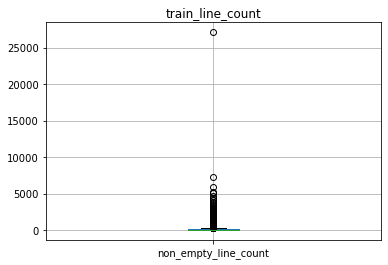

In [9]:
df_train.boxplot(column=['non_empty_line_count'])
plt.title('train_line_count')
plt.show()

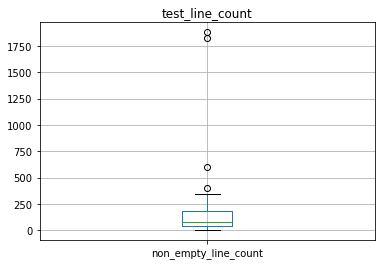

In [10]:
df_test.boxplot(column=['non_empty_line_count'])
plt.title('test_line_count')
plt.show()

In [11]:
df_test.loc[df_test['non_empty_line_count'].idxmax()]

index                                                                  49
filename                data_IanLewis_kay_kay_lib_werkzeug_datastructu...
non_empty_line_count                                                 1878
is_init                                                             False
root_class_count                                                       31
root_function_count                                                     4
Name: 49, dtype: object

In [12]:
df_train.loc[df_test['non_empty_line_count'].idxmax()]

index                                                                  49
filename                data_lsaffre_lino_lino_modlib_plausibility___i...
non_empty_line_count                                                   84
is_init                                                              True
root_class_count                                                        1
root_function_count                                                     0
Name: 49, dtype: object